## Model

In [16]:
import cv2
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import keras
from keras import layers, ops
import matplotlib.pyplot as plt
SEED = 42
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
keras.utils.set_random_seed(SEED)

# operations are evaluated immediately and return their values 
# instead of constructing a computational graph to execute later
tf.config.run_functions_eagerly(True) 

In [2]:
# retrieve所有video的名字

frames_path = 'data/frames/'
frames_path_normal = 'data/frames/Normal/'
frames_path_crash = 'data/frames/Crash/'

frames_name_normal = sorted([f for f in os.listdir(frames_path_normal)])
frames_name_crash = sorted([f for f in os.listdir(frames_path_crash)])

In [35]:
# 我只要50个video
# 这个不是随机的哦，只是我觉得方便先那么写着

frames_name_normal_valid = frames_name_normal[26:28]
frames_name_crash_valid = frames_name_normal[26:28]
frames_name_normal = frames_name_normal[1:26]
frames_name_crash = frames_name_crash[1:26]

In [4]:
# 三七分 train test split

train_normal, test_normal = train_test_split(frames_name_normal,test_size=0.3, random_state=42)

train_crash, test_crash = train_test_split(frames_name_crash, test_size=0.3, random_state=42)

In [27]:
# `##` --> Adjustable

# DATA
IMG_SIZE = 128  ## Image size (128, 128) in this case
CHAN_SIZE = 1   ## 1-GrayScale; 3-RGB - 结果一样（如果其它数值不变）
BATCH_SIZE = 8  ## 教程给的是 32 - 我没动过，可以调一下这个
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (50, IMG_SIZE, IMG_SIZE, CHAN_SIZE)
NUM_CLASSES = 2  ## 1-Crash; 0-Normal

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
# EPOCHS = 10   ## 这个我放到下面了

# TUBELET EMBEDDING
PATCH_SIZE = (8,8,8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
EMBED_DIM = 64  ## Size of the feature vectors transformed from the input
NUM_HEADS =  6   ##
NUM_LAYERS = 6   ##

In [6]:
# Load data

def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=CHAN_SIZE)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0 # Normalization
    return image

train_videos = []
test_videos = []
train_labels = []
test_labels = []

for t in train_normal:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_normal + t + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_normal + t + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    train_videos.append(video.numpy())
    train_labels.append(0)
    
for t in test_normal:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_normal + t + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_normal + t + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    test_videos.append(video.numpy())
    test_labels.append(0)

for t in train_crash:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_crash + t + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_crash + t + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    train_videos.append(video.numpy())
    train_labels.append(1)
    
for t in test_crash:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_crash + t + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_crash + t + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    test_videos.append(video.numpy())
    test_labels.append(1)

    
valid_videos = []
valid_labels = []
    
for t in frames_name_crash_valid:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_crash + t + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_crash + t + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    valid_videos.append(video.numpy())
    valid_labels.append(1)

for t in frames_name_normal_valid:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_crash + t + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_crash + t + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    valid_videos.append(video.numpy())
    valid_labels.append(0)

In [7]:
train_videos = np.asarray(train_videos)
test_videos = np.asarray(test_videos)
train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)
valid_videos = np.asarray(valid_videos)
valid_labels = np.asarray(valid_labels)

# print(len(train_videos), len(train_labels)) # 34, 34
# print(len(test_videos), len(test_labels)) # 16, 16

In [8]:
# Create Dataloader

def preprocess(frames: tf.Tensor, label: tf.Tensor):
    """Preprocess the frames tensors and parse the labels."""
    # Preprocess images
    frames = tf.image.convert_image_dtype(
        frames[
            ..., tf.newaxis
        ],  # The new axis is to help for further processing with Conv3D layers
        tf.float32,
    )
    # Parse label
    label = tf.cast(label, tf.float32)
    return frames, label



def prepare_dataloader(
    videos: np.ndarray,
    labels: np.ndarray,
    loader_type: str = "train",
    batch_size: int = BATCH_SIZE,
):
    """Utility function to prepare the dataloader."""
    dataset = tf.data.Dataset.from_tensor_slices((videos, labels))

    if loader_type == "train":
        dataset = dataset.shuffle(BATCH_SIZE * 2)

    dataloader = (
        dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )
    return dataloader


trainloader = prepare_dataloader(train_videos, train_labels, "train")
testloader = prepare_dataloader(test_videos, test_labels, "test")
validloader = prepare_dataloader(valid_videos, valid_labels, "valid")

In [9]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        
        # `projected_patches`
        # dividing the input into patches (determined by kernel_size and strides) 
        # and transforming each patch into an 64-dimensional embedding.
        
        projected_patches = self.projection(videos) 
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches

In [10]:
class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = ops.arange(0, num_tokens, 1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

In [17]:
# class CustomMultiHeadAttention(layers.Layer):
#     def __init__(self, num_heads, key_dim, dropout=0, **kwargs):
#         super().__init__(**kwargs)
#         self.attention = layers.MultiHeadAttention(
#             num_heads=num_heads, key_dim=key_dim, dropout=dropout
#         )

#     def call(self, query, value):
#         attention_output, attention_scores = self.attention(query, value, value)
#         return attention_output, attention_scores

In [158]:
def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=EMBED_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=NUM_CLASSES
):
    # Get the input layer
    inputs = layers.Input(shape=input_shape) # shape=(50,128,128,1)
    # Create patches
    patches = tubelet_embedder(inputs)
    # Encode patches
    encoded_patches = positional_encoder(patches)


    for _ in range(transformer_layers):
        
        # 1. Layer normalization and MultiHeadAttention
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        
        # 2. The MultiHeadAttention
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)
        
        # 3. Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])
        
        # 4. Layer Normalization and MultiLayerPerception
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # 5. The two fully-connected layers with GELU activation functions
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim, activation=ops.gelu), 
                layers.Dense(units=embed_dim, activation=ops.gelu),
            ]
        )(x3)
        
#         x3 = keras.Sequential(
#             [
#                 layers.Dense(units=embed_dim*4, activation=ops.gelu), 
#                 layers.Dense(units=embed_dim, activation=ops.gelu),
#             ]
#         )(x3)
        
        # 6. Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs.
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [159]:
def run_experiment():
    # Initialize model
    model = create_vivit_classifier(
        tubelet_embedder=TubeletEmbedding(
            embed_dim=EMBED_DIM, patch_size=PATCH_SIZE
        ),
        positional_encoder=PositionalEncoder(embed_dim=EMBED_DIM)
    )

    # Compile the model with the optimizer, loss function and the metrics.
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    # Train the model
    history = model.fit(trainloader, epochs=6, validation_data=validloader)

    # Evaluate the model
    loss, accuracy, top_5_accuracy = model.evaluate(testloader)
    
    print()
    print(f"Test accuracy: {accuracy * 100}%")

    return model, history

model, history = run_experiment()

Epoch 1/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 47s 9s/step - accuracy: 0.5821 - loss: 1.1231 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.9864 - val_top-5-accuracy: 1.0000
Epoch 2/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 8s/step - accuracy: 0.5404 - loss: 0.6737 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.7439 - val_top-5-accuracy: 1.0000
Epoch 3/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 52s 10s/step - accuracy: 0.8833 - loss: 0.4149 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 1.0305 - val_top-5-accuracy: 1.0000
Epoch 4/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 50s 10s/step - accuracy: 0.8729 - loss: 0.4558 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 1.0759 - val_top-5-accuracy: 1.0000
Epoch 5/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 47s 9s/step - accuracy: 0.8242 - loss: 0.4361 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.9294 - val_top-5-accuracy: 1.0000
Epoch 6/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 9s/step - accuracy: 0.8746 - loss: 0.3268 - top-5-accuracy: 1.0000 - val_a

## Visualization

**正在实验的数据**

In [137]:
# Summary

# model.summary()

**Goal**

1. Plot histograms of the weights. This can show you the distribution of weights across each layer.

Normally distributed weights or weights centered around zero are generally a good sign, indicating that the weights are well-regularized and the layer is learning diverse features. Extremely large weights or very skewed distributions can indicate potential issues with training, such as exploding gradients.

2. Graph hetmaps of the weights. Identify patterns or structures in the weights. 

Showing how different input features may be interconnected or weighted in the output.

3. Examine association between embedded dimension and video vision transformer model performance

The analysis should ideally extend to understanding how these layers transform inputs into outputs, influencing the model’s accuracy and robustness.

**The two fully-connected layers with GELU activation functions**

In [160]:
# Record Dense Layer Weights and Bias
"""
x3 = keras.Sequential(
    [
        layers.Dense(units=embed_dim, activation=ops.gelu),
        layers.Dense(units=embed_dim, activation=ops.gelu),
    ]
)(x3)
"""

weights = []

for layer in model.layers:
    if (layer.__class__.__name__ == "Sequential"):
        weights.append(layer.get_weights())

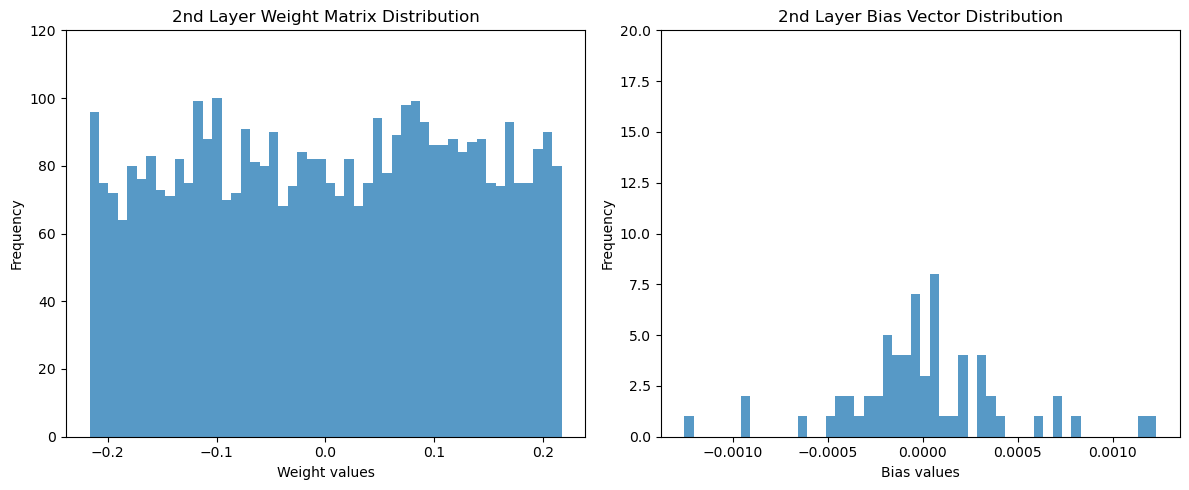

In [210]:
# for w in weights:
w = weights[-1]

# SparseCategoricalAccuracy
# weight_matrix_1 = w[0]
# bias_matrix_1 = w[1]

# SparseTopKCategoricalAccuracy
weight_matrix_2 = w[2]
bias_matrix_2 = w[3]

# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.title("1st Layer Weight Matrix Distribution")
# plt.hist(weight_matrix_1.flatten(), bins=50, alpha=0.75)
# plt.xlabel("Weight values")
# plt.ylabel("Frequency")
# plt.ylim(0, 120)
# plt.subplot(1, 2, 2)
# plt.title("1st Layer Bias Vector Distribution")
# plt.hist(bias_matrix_1.flatten(), bins=50, alpha=0.75)
# plt.xlabel("Bias values")
# plt.ylabel("Frequency")
# plt.ylim(0, 20)
# plt.tight_layout()
# plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("2nd Layer Weight Matrix Distribution")
plt.hist(weight_matrix_2.flatten(), bins=50, alpha=0.75)
plt.xlabel("Weight values")
plt.ylabel("Frequency")
plt.ylim(0, 120)
plt.subplot(1, 2, 2)
plt.title("2nd Layer Bias Vector Distribution")
plt.hist(bias_matrix_2.flatten(), bins=50, alpha=0.75)
plt.xlabel("Bias values")
plt.ylabel("Frequency")
plt.ylim(0, 20)
plt.tight_layout()
plt.show()

In [218]:
w = weights[-1]
weight_matrix_2 = w[2]
bias_matrix_2 = w[3]

In [220]:
import pandas as pd

pd.DataFrame(weight_matrix_2) 
# Row    - One Feature to All Outcome     (Outcome number = EMBED_DIM)
# Column - All Features to Single Outcome (Feature number = EMBED_DIM)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.114983,-0.202845,0.171735,0.079536,0.180911,-0.181774,-0.029187,0.116293,-0.037206,-0.026175,...,-0.165647,-0.029160,0.108372,-0.005273,-0.118938,-0.130921,0.146000,0.067661,-0.161077,0.158902
1,-0.143856,0.049657,-0.055246,-0.138103,0.022040,0.131820,0.089666,0.073388,0.094090,0.119536,...,0.197142,-0.190151,0.116747,-0.110504,-0.098733,-0.153290,0.096694,-0.077268,-0.143009,0.019431
2,0.175167,0.163830,0.027354,0.066606,-0.038111,0.009871,0.049710,0.094812,-0.055586,0.138056,...,-0.022909,-0.019828,-0.017333,0.143934,-0.159736,-0.132839,-0.137041,-0.173599,0.110435,0.110804
3,0.013856,-0.193967,-0.206905,0.190177,-0.075483,-0.048760,0.065372,0.062681,-0.010612,-0.186821,...,0.151753,-0.166447,0.015291,0.112077,0.103160,0.130303,-0.030167,-0.158055,0.010321,-0.137901
4,0.058657,0.093010,0.084900,0.041577,0.071065,0.052652,0.142479,0.121834,-0.058209,-0.041236,...,0.109504,0.198001,-0.117970,0.215495,-0.057696,-0.038493,0.028495,0.071599,0.142857,0.000633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.096434,-0.112122,0.011199,-0.046243,0.206879,-0.015819,0.148014,0.092869,0.201370,0.066120,...,-0.099679,0.085760,0.199482,0.041181,0.215122,-0.079666,-0.213733,-0.010307,0.112687,-0.087693
60,0.100322,-0.128893,-0.042174,-0.093020,0.131239,-0.080144,0.123745,0.111349,0.020968,0.108929,...,-0.009837,-0.002356,0.115439,0.051567,0.095526,0.112523,0.112889,0.091608,-0.162988,-0.127794
61,0.044397,0.160780,0.141789,0.110641,0.059702,-0.021392,0.024752,0.062545,-0.080364,-0.060008,...,-0.007654,-0.170446,0.022948,-0.030974,-0.094780,0.038570,0.076243,-0.207447,-0.040626,-0.196294
62,-0.013605,0.117022,-0.031879,-0.026896,-0.181313,-0.033654,0.070345,-0.123904,-0.006412,-0.210873,...,0.183570,-0.113778,0.067234,-0.197453,0.022980,-0.216040,0.182150,0.185776,0.129698,0.049138


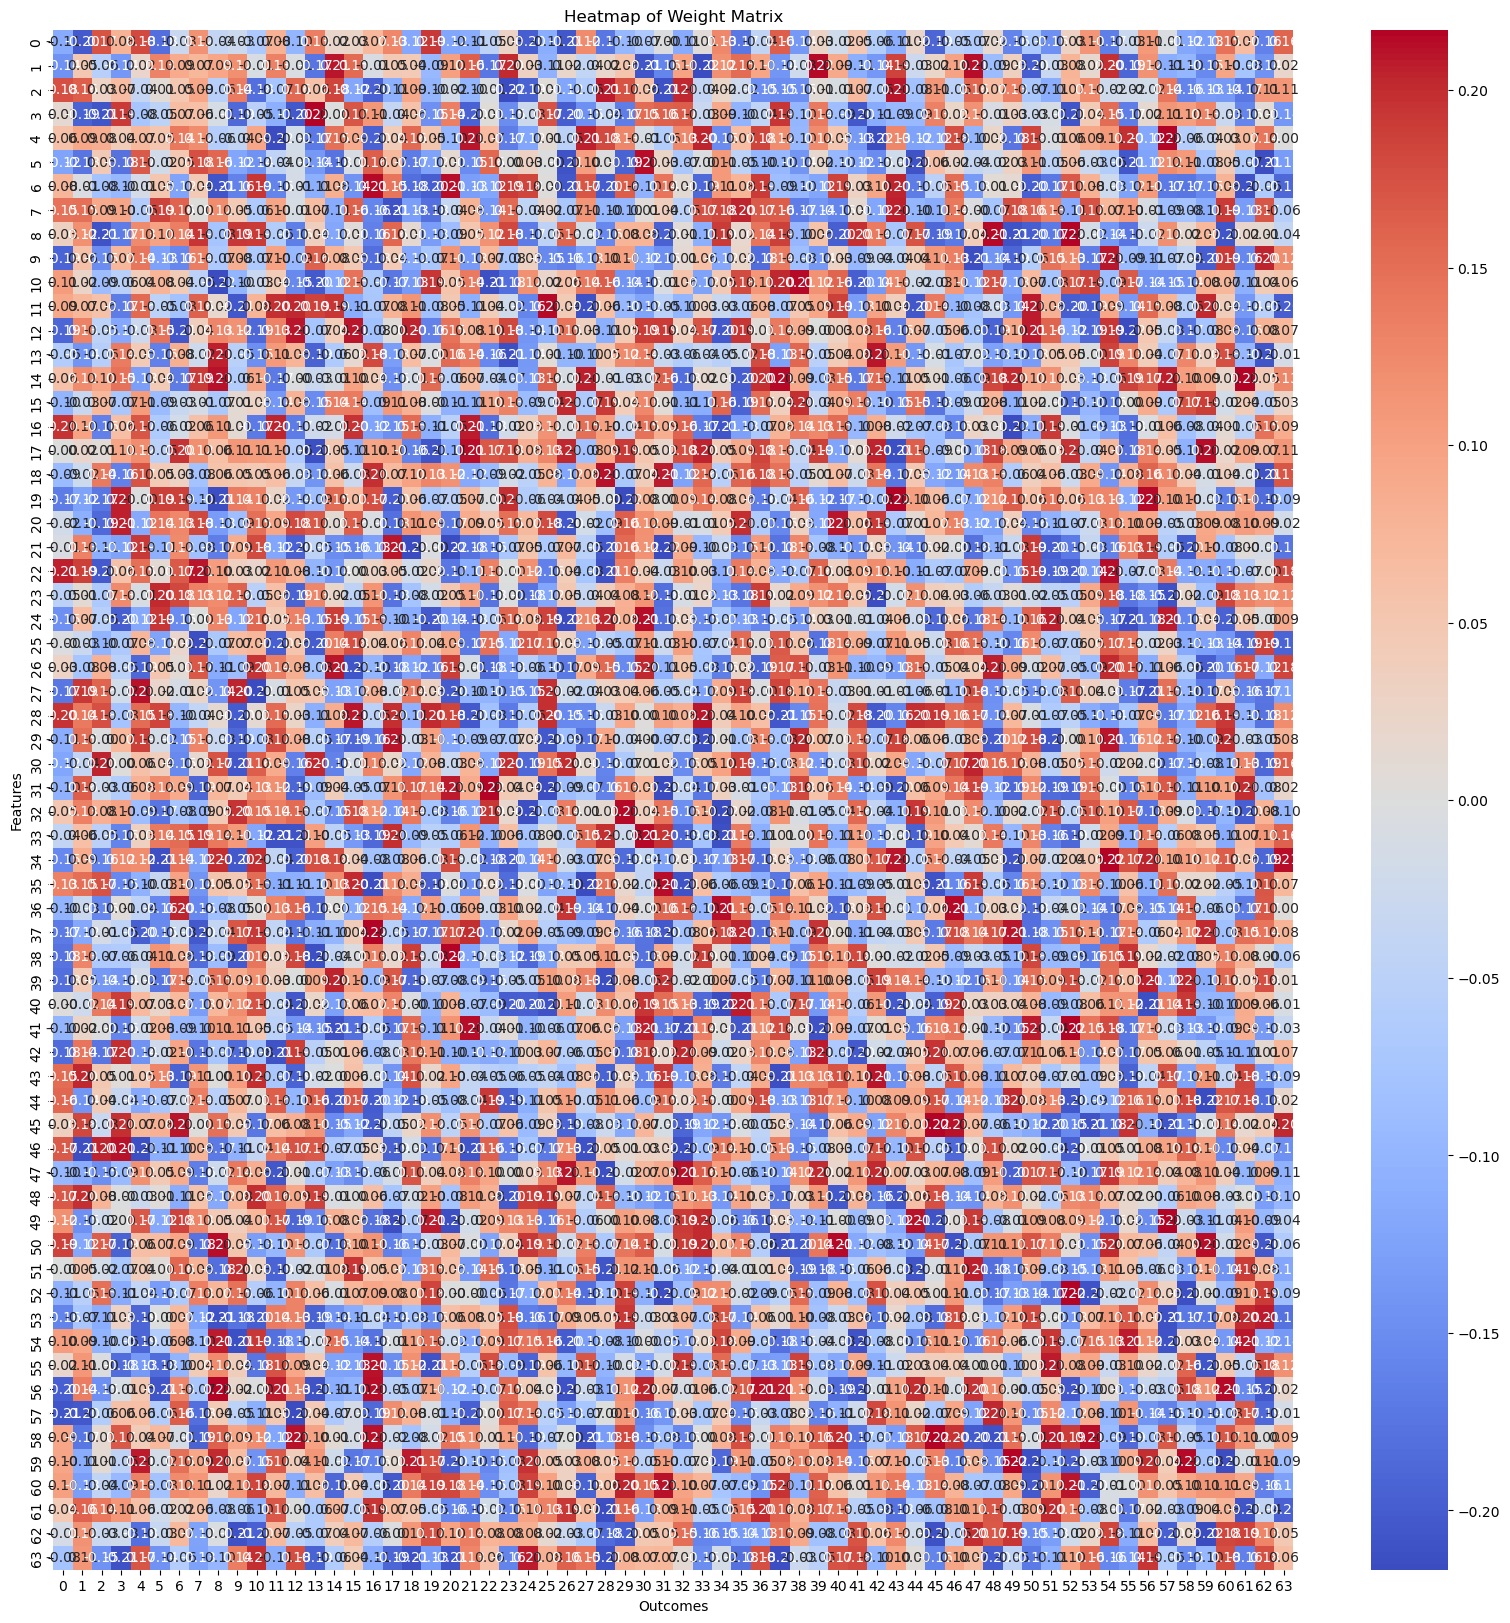

In [225]:
import seaborn as sns

plt.figure(figsize=(20, 20))
sns.heatmap(weight_matrix_2, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Weight Matrix')
plt.xlabel('Outcomes')
plt.ylabel('Features')
plt.show()

In [222]:
# Let's Examine How 
# based on the Features/Rows of the very last dense layer

negative_features_indicies = []
negative_features_avgweights = []
positive_features_indicies = []
positive_features_avgweights = []

for i in range(len(weight_matrix_2)):

    # Each row is a feature
    # So this shows the average rate of each feature

    avg_weight = sum((weight_matrix_2[i])/len(weight_matrix_2[i]))
    # print("Avg Weight "+str(i+1))
    # print(avg_weight)
    # print()

    if (avg_weight > 0):
        positive_features_indicies.append(i+1)
        positive_features_avgweights.append(avg_weight)
    else:
        negative_features_indicies.append(i+1)
        negative_features_avgweights.append(avg_weight)
        
print(max(negative_features_avgweights), max(positive_features_avgweights))

-0.0003680096342577599 0.0519180805022188


**Incorrect Classification**

Prediction: Normal 0.56714135
Actual: Crash 000001.mp4

Prediction: Normal 0.52392995
Actual: Crash 000012.mp4

Prediction: Normal 0.5323965
Actual: Crash 000010.mp4

Prediction: Normal 0.6415799
Actual: Crash 000002.mp4

Prediction: Crash 0.68010837
Actual: Normal 000010.mp4

In [199]:
# # Evaluate 16 testing videos

model_predict_test = model.predict(testloader)

for i in range(16):
    crash_conf = model_predict_test[i][0]
    normal_conf = model_predict_test[i][1]
    if (crash_conf > normal_conf):
        print("Prediction: Crash", crash_conf)
    else:
        print("Prediction: Normal", normal_conf)
    if (i < 8):
        print("Actual: Crash", test_normal[i]+".mp4")
    else:
        print("Actual: Normal", test_crash[abs(i-8)]+".mp4")
    print()

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
Prediction: Crash 0.92446923
Actual: Crash 000009.mp4

Prediction: Crash 0.92712563
Actual: Crash 000017.mp4

Prediction: Normal 0.56714135
Actual: Crash 000001.mp4

Prediction: Crash 0.9873251
Actual: Crash 000024.mp4

Prediction: Normal 0.52392995
Actual: Crash 000012.mp4

Prediction: Normal 0.5323965
Actual: Crash 000010.mp4

Prediction: Crash 0.93823916
Actual: Crash 000014.mp4

Prediction: Normal 0.6415799
Actual: Crash 000002.mp4

Prediction: Normal 0.71388865
Actual: Normal 000009.mp4

Prediction: Normal 0.83966595
Actual: Normal 000017.mp4

Prediction: Normal 0.5716479
Actual: Normal 000001.mp4

Prediction: Normal 0.6735209
Actual: Normal 000024.mp4

Prediction: Normal 0.56779206
Actual: Normal 000012.mp4

Prediction: Crash 0.68010837
Actual: Normal 000010.mp4

Prediction: Normal 0.7576069
Actual: Normal 000014.mp4

Prediction: Normal 0.58930707
Actual: Normal 000002.mp4



## (0) Overall distribution
## (1) What is the embeded dim?
## (2) Find the top 5 indicies where the result is influenced, both positively and negatively?
## (3) What are their associated weights and biases by embeded dim?
## (4) What are the corresponding result?
## (5) What is the resulting distribution if I were to change embeded dim?

**能直接用的一些数据**

In [ ]:
# # Accuracy and Loss

# plt.plot(history.history['accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# plt.plot(history.history['loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

**不能用的数据：attention_scores 是KerasTensor，不能convert成 Numpy Array所以画不了图**

In [71]:
# # https://stackoverflow.com/questions/70573362/tensorflow-how-to-extract-attention-scores-for-graphing

# EMBED_DIM = 64
# PATCH_SIZE = 8,8,8
tubelet_embedder = TubeletEmbedding(embed_dim=EMBED_DIM, patch_size=PATCH_SIZE)
positional_encoder = PositionalEncoder(embed_dim=EMBED_DIM)

# INPUT_SHAPE = (50, 128, 128, 1)
inputs = layers.Input(shape=INPUT_SHAPE)

# Create patches
patches = tubelet_embedder(inputs)

# Encode patches
encoded_patches = positional_encoder(patches)

x = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

attention_output = model.layers[4](x,x)

evaluated_output = tf.keras.backend.eval(attention_output)

# output = model.predict(x[0])  ## ERROR

ValueError: A KerasTensor is symbolic: it's a placeholder for a shape an a dtype. It doesn't have any actual numerical value. You cannot convert it to a NumPy array.